# <span style="color:green"> Numerical Simulation Laboratory (NSL) Exercise 6 Results </span>

## 06.1

Add the calculation of $C(N,T)$, $\chi(N,T)$, $M(N,T,h)$ and compute:
1. $U(N,T) = \langle H \rangle_{h=0}$
2. $C(N,T) = k_B \beta^2 (\langle H^2 \rangle_{h=0}-\langle H \rangle_{h=0}^2)$ 
3. $\chi(N,T) = \beta \langle (\sum_{i=1,N}s_i)^2 \rangle_{h=0}$
4. $M(N,T,h=0.02)= \langle \sum_{i=1,N}s_i \rangle_{h=0.02}$

as a function of $T$ in the range $\left[0.5;2.0\right]$ for a system of $N=50$ spins with $J=1$.

Add the possibility to restart from a previous spin configuration.

As usual, use data blocking and give an estimate of the statistical uncertainties.

- <span style="color:red">Show pictures of your estimations of $U(N,T)$, $C(N,T)$, $\chi(N,T)$, $M(N,T,h=0.02)$ and their uncertainties</span> obtained with a large number of *MC steps* (e.g. $M\ge 10^5$) compared with the exact curves. In the same picture show your results obtained with both sampling methods, Metropolis and Gibbs.

Do not forget to equilibrate your simulations and to use blocking average with blocks large enough.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import os
import re

path = os.path.join(os.getcwd(), "6")

blocks = 10
steps = 10**4

In [90]:
# TA = np.arange(0.2, 3.2, step = 0.1)
TA = np.logspace(0.01, 1, num = 30) * 0.32

Ns = 50 # number of spins

h = 0
J = 1.0

def autocorr(x, t):
    t_max = x.size
    return ( np.dot(x[:t_max-t], x[t:t_max]) / (t_max - t) 
            - np.sum(x[:t_max-t]) * np.sum(x[t:t_max]) / (t_max - t)**2 ) /  np.var(x)

In [117]:
def create_input_file(T, Ns, Jm, Hm, Sampling, Blocks, Steps, Equi_steps):
    with open(f"{path}/input.dat", 'w') as new_config:
        with open(f'{path}/input_origin.dat', 'r') as template_config:
            config = template_config.read()
            config = re.sub("{T}", str(T), config)
            config = re.sub("{Ns}", str(Ns), config)
            config = re.sub("{Jm}", str(Jm), config)
            config = re.sub("{Hm}", str(Hm), config)
            config = re.sub("{Sampling}", str(Sampling), config)
            config = re.sub("{Old_Configuration}", str(0), config)
            config = re.sub("{Blocks}", str(Blocks), config)
            config = re.sub("{Steps}", str(Steps), config)
            config = re.sub("{Equilibration}", str(Equi_steps), config)
            new_config.write(config)

def equilibration(T, equi_steps, FORCE_NEW_RUN):
    plt.rcParams['figure.figsize'] = (15,10)
    blocks = 0
    steps = 0
    equilibration = equi_steps
    status = { 'usual', 'different configuration'}
    t =np.arange(equilibration)*50
    U = np.zeros(equilibration)
    U_shift = np.zeros(equilibration)
  
    if FORCE_NEW_RUN:
        subprocess.run(["bash", "./clean.sh"], cwd=path)
        create_input_file(T,50,1.0,0.0,1,blocks,steps, equi_steps)
        subprocess.run(["./Monte_Carlo_ISING_1D"], cwd=path)
        U = np.loadtxt(f'{path}/equi.mag.0')
        U_shift = np.loadtxt(f'{path}/equi.mag.1')
        np.savetxt(f'{path}/equilibration.dat',np.c_[U, U_shift],delimiter=' ')
    else:
        U, U_shift = np.loadtxt(f'{path}/equilibration.dat', unpack = True)
    plt.plot(t, U, '.-', color= 'r', label='Magnetic susceptibility with original seed')
    plt.plot(t, U_shift, '.-', color= 'b',  label='Magnetic susceptibility with different seed')
    plt.title(r'$\chi$ equilibration')
    plt.xlabel('Monte Carlo steps')
    plt.ylabel(r'$\chi$')
    plt.legend()

def autocorrelation(Nsteps, FORCE_NEW_RUN):
    M = 1
    path = os.path.join(os.getcwd(), "6/")
    t =np.arange(Nsteps*M)
    S =np.arange(Nsteps*M)*50
    A = np.zeros(Nsteps*M)
    B = np.zeros(Nsteps*M)
    
    plt.title(r'Autocorrelation Potential Energy per particle')
    plt.ylabel(r'$\chi(Mstep)$')
    plt.xlabel('Monte Carlo Steps')
   
   
    
    if FORCE_NEW_RUN:
        subprocess.run(["bash", "./clean.sh"], cwd=path)
        create_input_file(1.2,50,1.0,0.0,1,M,Nsteps, 1000)
        subprocess.run(["./Monte_Carlo_ISING_1D"], cwd=path)
        chi = np.loadtxt(f"{path}/block.ene.dat", unpack=True)
        A = np.vectorize(autocorr, excluded=[0])(chi, t)
        np.savetxt(f'{path}/autocorrelation.dat',np.c_[A],delimiter=' ')
    else:
        A = np.loadtxt(f'{path}/autocorrelation.dat', unpack = True)
    plt.plot(S, A, '.')
    plt.axhspan(-0.1, 0.1, alpha=0.2)
    plt.axhline(0)
    plt.xlim(0.,2000)
    
def plot_mc(mode):    
    T = np.linspace(TA[0],TA[-1],num=100)
    th = np.tanh(J/T)
    thN= th**Ns
    ch = 1/th
    beta = 1/T
        
    if mode == 'energy':
        Y_gibbs = U_gibbs
        Yerr_gibbs = Uerr_gibbs
        Y_metro = U_metro
        Yerr_metro = Uerr_metro
        y = -J*( th + ch*thN )/( 1 + thN )
        ylabel = 'U/N'
        title = 'Ising 1D, internal energy'
    elif mode == 'magnetization':
        Y_gibbs = M_gibbs
        Yerr_gibbs = Merr_gibbs
        Y_metro = M_metro
        Yerr_metro = Merr_metro
        h = 0.02
        l1 = np.exp(beta*J)*np.cosh(beta*h)+np.sqrt(np.exp(2*beta*J)*np.cosh(beta*h)*np.cosh(beta*h)-2*np.sinh(2*beta*J))
        l2 = np.exp(beta*J)*np.cosh(beta*h)-np.sqrt(np.exp(2*beta*J)*np.cosh(beta*h)*np.cosh(beta*h)-2*np.sinh(2*beta*J))
        Z = l1**Ns + l2**Ns
        y = (np.exp(beta*J)*np.sinh(beta*h)*((l1**(Ns-1))*(1+np.exp(beta*J)*np.cosh(beta*h)/np.sqrt(np.exp(2*beta*J)*np.cosh(beta*h)*np.cosh(beta*h)-2*np.sinh(2*beta*J))) 
        + (l2**(Ns-1))*(1-np.exp(beta*J)*np.cosh(beta*h)/np.sqrt(np.exp(2*beta*J)*np.cosh(beta*h)*np.cosh(beta*h)-2*np.sinh(2*beta*J)))))/(Z)
        ylabel = '$M$'
        title = 'Ising 1D, magnetization M with h = 0.02'
    elif mode == 'heat':        
        Y_gibbs = H_gibbs
        Yerr_gibbs = Herr_gibbs
        Y_metro = H_metro
        Yerr_metro = Herr_metro
        y = ((beta*J)**2)*(((1+thN+(Ns-1)*(th**2)+(Ns-1)*(ch**2)*thN)/(1+thN))-Ns*((th+ch*thN)/(1+thN))**2)
        ylabel = 'C'
        title = 'Ising 1D, Heat capacity'        
    elif mode == 'susceptibility':        
        Y_gibbs = X_gibbs
        Yerr_gibbs = Xerr_gibbs
        Y_metro = X_metro
        Yerr_metro = Xerr_metro
        y = beta*np.exp(2*beta*J)*(1-thN)/(1+thN)
        ylabel = '$\chi$'
        title = 'Ising 1D, Susceptibility'    
    
    plt.figure(figsize=(15,8))
    plt.plot(T, y)
    plt.errorbar(TA, Y_metro, yerr=Yerr_metro, marker='o', linestyle='', label='Metropolis')
    plt.errorbar(TA, Y_gibbs, yerr=Yerr_gibbs, marker='o', linestyle='', label='Gibbs')
    plt.title(title)
    plt.xlabel('T')
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()


In [119]:
H_metro = np.zeros_like(TA)
Herr_metro = np.zeros_like(TA)
H_gibbs = np.zeros_like(TA)
Herr_gibbs = np.zeros_like(TA)

M_metro = np.zeros_like(TA)
Merr_metro = np.zeros_like(TA)
M_gibbs = np.zeros_like(TA)
Merr_gibbs = np.zeros_like(TA)

U_metro = np.zeros_like(TA)
Uerr_metro = np.zeros_like(TA)
U_gibbs = np.zeros_like(TA)
Uerr_gibbs = np.zeros_like(TA)

X_metro = np.zeros_like(TA)
Xerr_metro = np.zeros_like(TA)
X_gibbs = np.zeros_like(TA)
Xerr_gibbs = np.zeros_like(TA)


h = 0
for i in range(len(TA)):
    # Metropolis-Hasting sampling
    create_input_file(TA[i],50,1.0,h,1,blocks,steps,1000)
    subprocess.run(["./Monte_Carlo_ISING_1D"], cwd=path)
    sample, sample_err = np.loadtxt(f'{path}/outputFINAL.dat', unpack=True)
    (U_metro[i], _, H_metro[i], X_metro[i]) = sample
    (Uerr_metro[i], _, Herr_metro[i], Xerr_metro[i]) = sample_err
    
    # Gibbs sampling    
    create_input_file(TA[i],50,1.0,h,0,blocks,steps,1000)
    subprocess.run(["./Monte_Carlo_ISING_1D"], cwd=path)
    sample, sample_err = np.loadtxt(f'{path}/outputFINAL.dat', unpack=True)    
    (U_gibbs[i], _, H_gibbs[i], X_gibbs[i]) = sample
    (Uerr_gibbs[i], _, Herr_gibbs[i], Xerr_gibbs[i]) = sample_err
    
h = 0.02
for i in range(len(TA)):
    # Metropolis-Hasting sampling
    create_input_file(TA[i],50,1.0,h,1,blocks,steps,1000)
    subprocess.run(["./Monte_Carlo_ISING_1D"], cwd=path)
    sample, sample_err = np.loadtxt(f'{path}/outputFINAL.dat', unpack=True)
    M_metro[i] = sample[1]
    Merr_metro[i] = sample_err[1]
    
    # Gibbs sampling    
    create_input_file(TA[i],50,1.0,h,0,blocks,steps,1000)
    subprocess.run(["./Monte_Carlo_ISING_1D"], cwd=path)
    sample, sample_err = np.loadtxt(f'{path}/outputFINAL.dat', unpack=True)    
    M_gibbs[i] = sample[1]
    Merr_gibbs[i] = sample_err[1]

We show a plot to the equilibration fase, we've chose two different spins states in the $T \cong 0$ states and identify the time steps necessary to obtain the same value for magnetic susceptibility. 

As we can see after less than 200 iteration (equivalent to $1\times10^4$ Monte Carlo Steps) our two different simulation has reached a common stable value for $\chi$.  

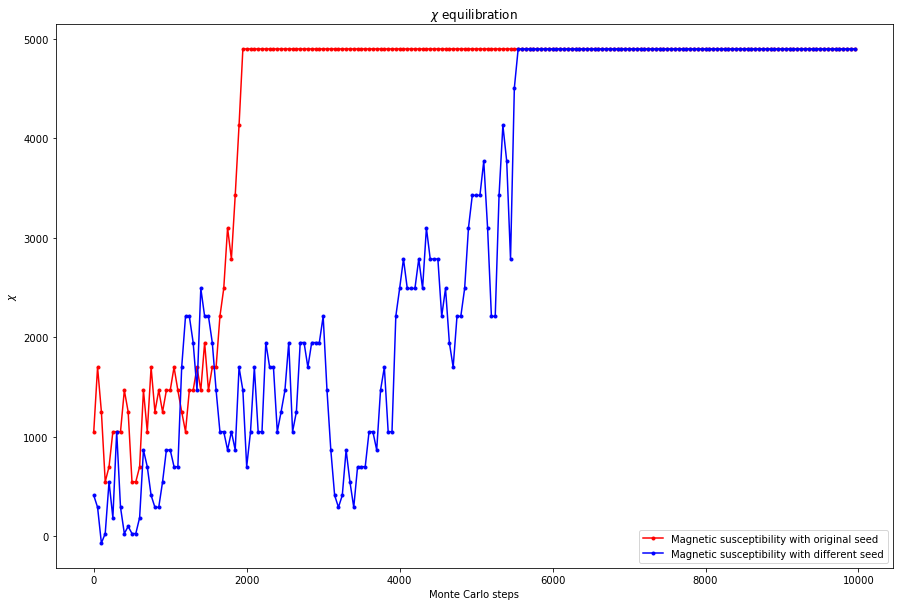

In [89]:
equilibration(0.01, 200, True)

For blocks dimension we've evaluated the autocorrelation function for the potential energy per particle, our results are presented below.

As depicted after 40 iteration, about $2\times 10^2$ steps the autocorrelation goes to zero, we've decided however to use very large blocks in our simulation.

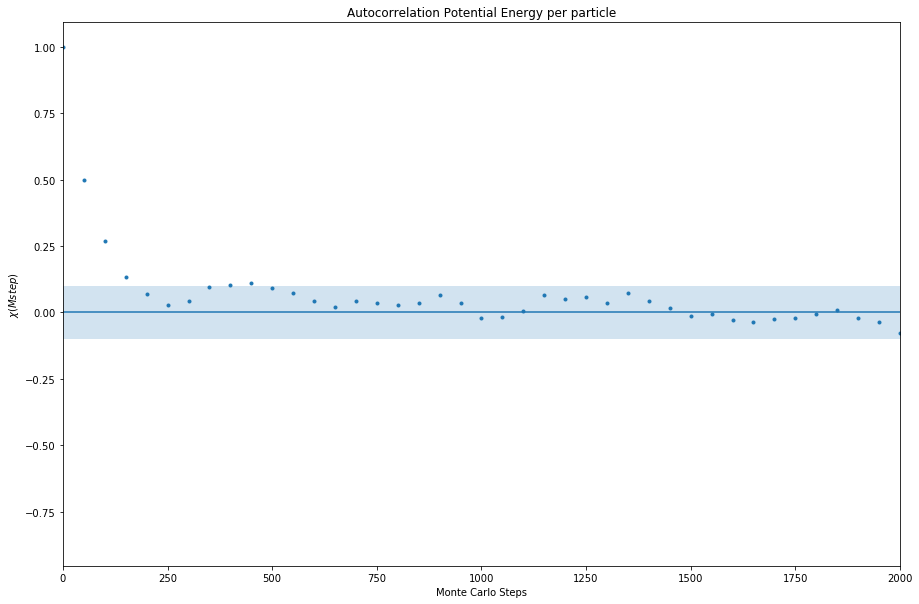

In [118]:
autocorrelation(1000, True)

We've done a series of program run for the different observables with data blocking, with 10 blocks and $M\ge 10^5$, then we've decided to use the final block value with its uncertanty for every simulation cicle to make the final plot for every observables.

We are aware that the same extimation obtained with a single simulation and temperature variation would surely be more efficient (and perhaps more within the exercise objective) but our initial (bad) comprehansion of the exercise led us to this (very strange) choice.

Temperature as been set from 0.01 to 3.0 with 20 simulation run and with more measurement below 1. 

In all the plots the exact curve are compared with Metropolis and Gibbs sampling.

In every situation our extimation and the exact curve have the same value, the only difference is the heat function.

Our extimation differ from more than two $\sigma$ in the temperature range between 0.5 and 1, that both with Gibbs and Metropolis samplign understimating the function.

We suppose that it's because of the high variation of the function in this range and increasing Monte Carlo steps does not solve this problem.

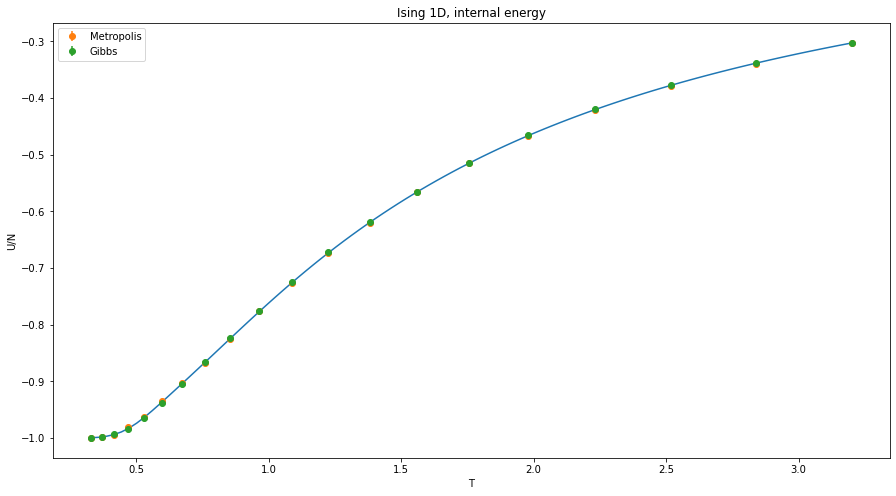

In [54]:
plot_mc('energy')

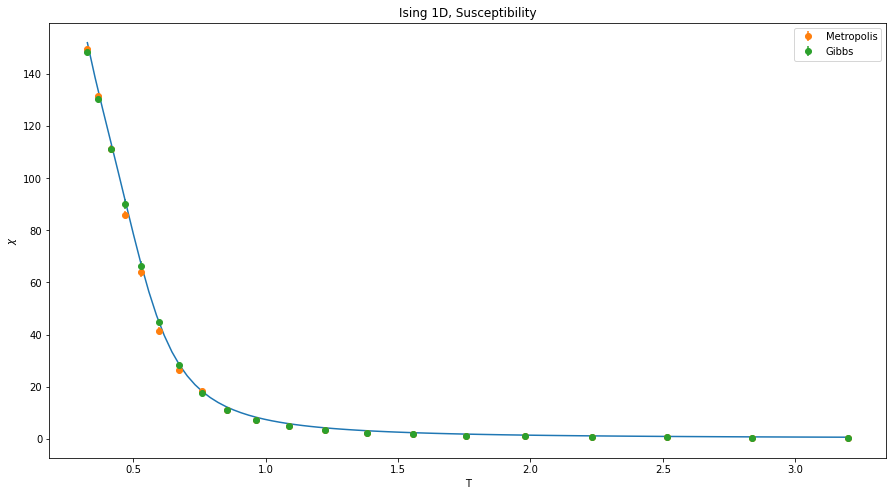

In [55]:
plot_mc('susceptibility')

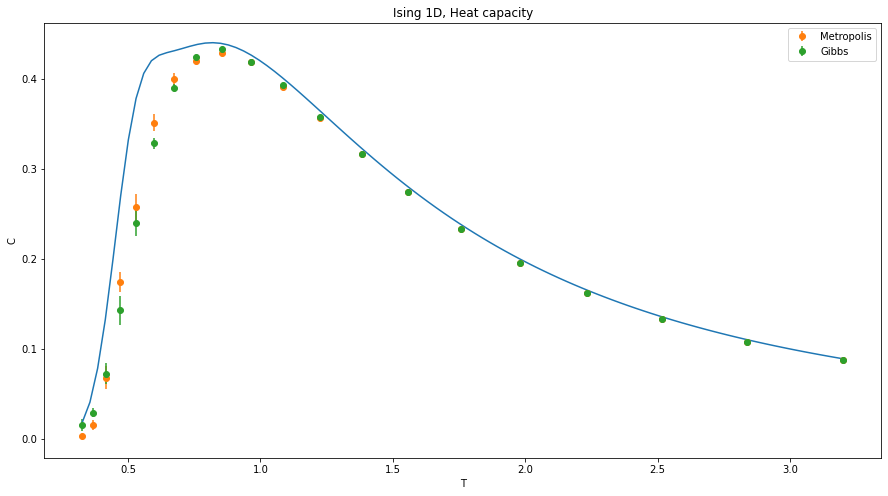

In [56]:
plot_mc('heat')

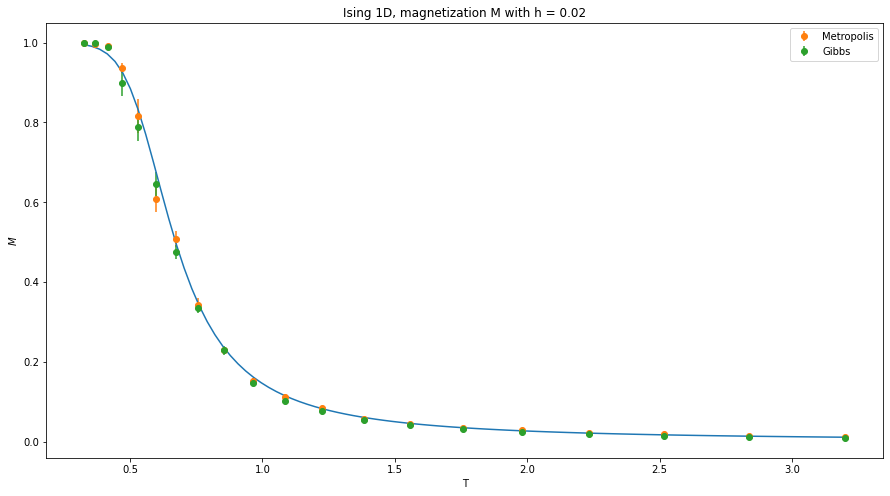

In [57]:
plot_mc('magnetization')